# Multi-Fidelity Bayesian Optimization: Investigating a Minimal Toy Problem

## Notes
We'll need to maintain a multioutput Gaussian Process surrogate for multifidelity Bayesian optimization. When using Gaussian Processes in the multifidelity scenario, one option is to extend the surrogate model through an autoregressive scheme:
$$
f^{(l)} = \rho f^{(l-1)}(\textbf{x}) + \delta^{l}(\textbf{x}), \;\; l = 2, \dots, L 
$$
where $\delta^{l}(\textbf{x}) \sim \mathcal{GP}(0, \kappa^{(l)}(\textbf{x}, \textbf{x}'))$ models the discrepancy between two adjoining levels of fidelity, and $\rho$ is a constant scaling factor.

## Desideratum
- [ ] We'll need a mechanism for computing covariances between input-fidelity pairs.
    - This poses a natural question: How do we choose our kernel function for evaluating the covariance between different fidelity levels?
- [x] Figure out if the white noise kernel is for ensuring the invertability of our linear system.
- [ ] Add support for optimize surrogates with arbitrary sum and product kernels.
    - The issue right now is that the constructor for each kernel needs to be provided to Optim and a manner that allows us to reconstruct the kernel iteratively for optimization

## Minimal Problem Exploration
To make sense of the methodology presented in `Non-Myopic Multifidelity Bayesian Optimization`, we'll reduce our problem to the simplest instance of the generalized problem. That is, we only consider two fidelity measures via the autoregressive scheme:
$$
    f^{(2)} = \rho f^{(1)}(\textbf{x}) + \delta^{2}(\textbf{x})
$$

Given some arbitrary $\textbf{x}$, we know our 

## Surrogate and Kernel Setup

In [1]:
using DelimitedFiles

In [2]:
include("../src/mfbo.jl")

optimize_surrogate (generic function with 1 method)

## 1. Gather Initial Samples
Our first step is to run some initial experiments and collect our data locations into some matrix $X$ and observations into some vector $y$. Our "experiments" will be random evaluations of some test function; in practice, our function is black-boxed.

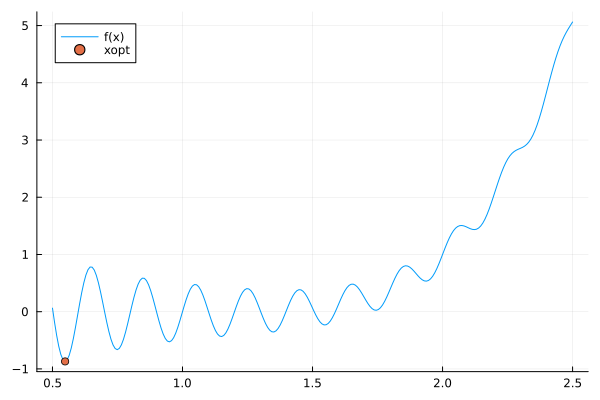

In [3]:
N, ϵ = 2, 1e-6
testfn, testfn_name, X, y = get_toy_problem(N=N, fn_name="GramacyLee")
lbs, ubs = testfn.bounds[:, 1], testfn.bounds[:, 2]
# testfn = TestLinearPlusCosine1D(1., 5., lb=0., ub=10.)
# X = randsample(N, testfn.dim, testfn.bounds[:, 1], testfn.bounds[:, 2])
# y = testfn(X) .+ ϵ * randn(N)
tplot(testfn)

When I say approximate, suppose we have some function $f: \chi \subset \mathbb{R}^d \to \mathbb{R}$ where $f$ is unknown but we have some observations $\mathcal{S}$ with $|\mathcal{S}| = n $. We say that $\hat{f}$ is an approximation of $f$ if the following holds under some norm $\mathcal{M}$:

$$
||\hat{f} - f||_{\mathcal{M}} \approx 0.
$$

where $f$ is usually unknown or costly to evaluate.

## 2. Initialize the surrogate model

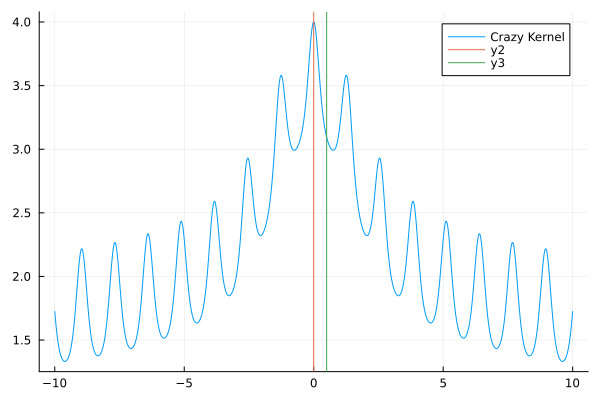

In [4]:
kernel = SquaredExponential(1.4) + RationalQuadratic(3., .82) + Periodic(1., 1.28) + Periodic(50., 4.2)
kernel_domain = -10.:.01:10.

plot(kernel_domain, [kernel([0.], [x]) for x in kernel_domain], label="Crazy Kernel")
vline!([0.])
vline!([.5])

$$
Kc = y
$$

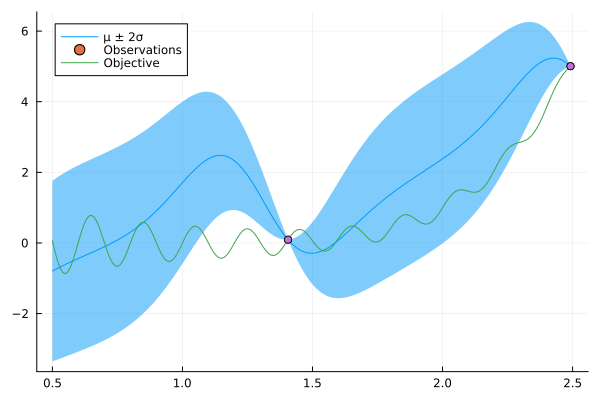

In [5]:
sur = GP(kernel, X, y, noise=ϵ)
# sur = optimize_surrogate(
#     gp=GP(kernel, X, y, noise=ϵ),
#     kernel_expression_tree=kernel,
#     lbs=.25 * ones(length(kernel)),
#     ubs=2. * ones(length(kernel)),
#     noise=ϵ,
#     random_restarts=12,
#     optim_options=Optim.Options(iterations=20)
# )

if testfn.dim == 1
    domain = get_dense_grid(testfn)
    plot1d(sur, interval=domain)
    plot!(domain, [testfn([x]) for x in domain], label="Objective")
    scatter!(sur.X', get_observations(sur), label=nothing)
else
    xx = range(testfn.bounds[1,1], testfn.bounds[1,2], length=100)
    yy = range(testfn.bounds[2,1], testfn.bounds[2,2], length=100)
    plot(xx, yy, (x,y) -> sur([x, y])[1], st=:contour)
end

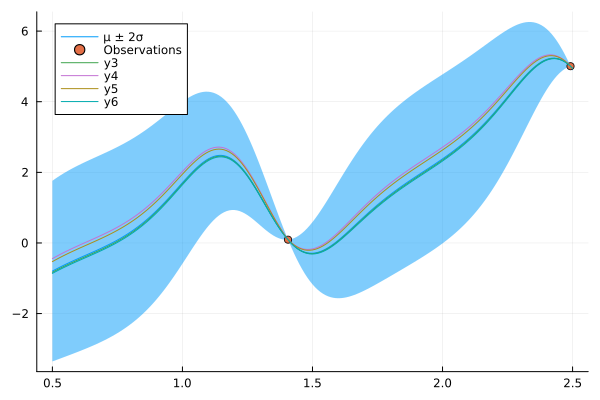

In [6]:
sampled_fs = []
SAMPLE_SIZE = 4

for i in 1:SAMPLE_SIZE
    stdnormal = randn()
    cur_sample = similar(domain)
    
    for (j, x) in enumerate(domain)
        cur_sample[j] = sample(sur, [x], gaussian=stdnormal)
    end
    
    push!(sampled_fs, cur_sample)
end

plot1d(sur, interval=domain)
[plot!(domain, sf) for sf in sampled_fs]
plot!()

In [7]:
Xnew = [1.;; .63;; 2.;; 1.3;; 2.3;; .5;; .7;; 2.4;; 2.45;; 2.5;; 1.8;; 1.85;; 2.25;; 2.2;; .8;; .9;; 1.5;; 1.6;; 1.2;; 1.1;;]
sur = naive_update(sur, Xnew, testfn(Xnew))
sur = optimize_surrogate(
    gp=GP(kernel, sur.X, sur.y, noise=ϵ),
    kernel_expression_tree=kernel,
    lbs=.1 * ones(length(kernel)),
    ubs=3. * ones(length(kernel)),
    noise=ϵ,
    random_restarts=12,
    optim_options=Optim.Options(iterations=20)
)

domain = get_dense_grid(testfn)
plot1d(sur, interval=domain)
plot!(domain, [testfn([x]) for x in domain], label="Objective")
scatter!(sur.X', get_observations(sur), label=nothing)

LoadError: MethodError: no method matching RationalQuadratic(::Vector{Float64}; nodify::Bool)

[0mClosest candidates are:
[0m  RationalQuadratic(; ...)
[0m[90m   @[39m [35mMain[39m [90m~/BO_Research/Multi-Fidelity-Bayesian-Optimization/src/[39m[90m[4mkernels.jl:362[24m[39m
[0m  RationalQuadratic([91m::AbstractFloat[39m, [91m::AbstractFloat[39m; nodify)
[0m[90m   @[39m [35mMain[39m [90m~/BO_Research/Multi-Fidelity-Bayesian-Optimization/src/[39m[90m[4mkernels.jl:362[24m[39m
[0m  RationalQuadratic([91m::AbstractFloat[39m; ...)
[0m[90m   @[39m [35mMain[39m [90m~/BO_Research/Multi-Fidelity-Bayesian-Optimization/src/[39m[90m[4mkernels.jl:362[24m[39m


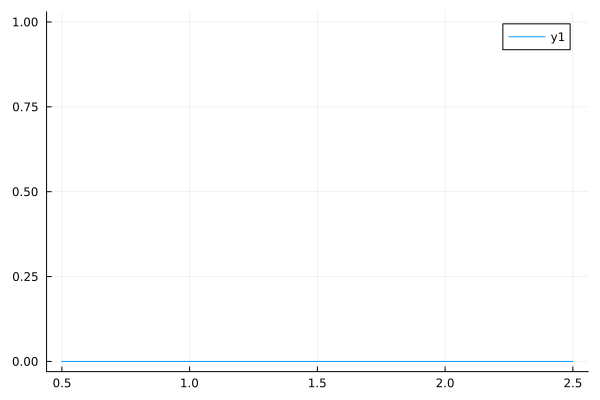

In [8]:
plotaf1d(POI(sur, lbs=lbs, ubs=ubs), interval=domain)

In [ ]:
xnew = optimize_acquisition(EI(sur, lbs=lbs, ubs=ubs))
testfn

In [ ]:
sample_sizes = domain

naive_timebytes = zeros(length(sample_sizes), 2)
schur_timebytes = similar(naive_timebytes)

naive_sur = GP(kernel, X, y, noise=ϵ)
schur_sur = GP(kernel, X, y, noise=ϵ)

# Investigating allocations and timing
for (i, x0) in enumerate(sample_sizes)
    print("|")
    xnew = randsample(1, testfn.dim, lbs, ubs)[:, 1]
    ynew = testfn(xnew)

    outcome = @timed begin
        naive_sur = naive_update(naive_sur, xnew, ynew)
    end
    naive_timebytes[i, 1] = outcome.time
    naive_timebytes[i, 2] = outcome.bytes

    outcome = @timed begin
        schur_sur = schur_update(schur_sur, xnew, ynew)
    end
    schur_timebytes[i, 1] = outcome.time
    schur_timebytes[i, 2] = outcome.bytes
end

In [ ]:
plot(schur_timebytes[:, 1], label="Schur Complement", title="Gaussian Process Updates")
plot!(naive_timebytes[:, 1], label="Naive")

In [ ]:
plot(cumsum(schur_timebytes[:, 2]), label="Schur Complement", title="Gaussian Process Allocations")
plot!(cumsum(naive_timebytes[:, 2]), label="Naive")

In [ ]:
bsur = BoundedGP(kernel, X, y, noise=ϵ, capacity=14);
domain = get_dense_grid(testfn)

plot1d(bsur, interval=domain)

## Gaussian Process Regression for Nonlinear Time Series

In [ ]:
data = readdlm("../data/co2_mm_mlo.csv", ',');

year, month, co2 = data[2:end, 1], data[2:end, 2], data[2:end, 4];
year_month = similar(year)

# Combine year and month into a single variable where the fractional part of
# the variable represents the month
for (i, payload) in enumerate(zip(year, month))
    cur_year, cur_month = payload
    year_month[i] = cur_year + cur_month / 12.
end

xtrain = year_month[year_month.<2018]; ytrain = co2[year_month.<2018];
xtest = year_month[year_month.>=2018]; ytest = co2[year_month.>=2018];

## On Modeling Separable Gaussian Processes via Additive Kernels
Given a random process $f(x) = f_1(x) + f_2(x)$, where $f_1, f_2$ are independent, then $k(x, y) = k_1(x, y) + k_2(x, y)$. Given a kernel $k: \chi^2 \to \mathbb{R}$ where $\chi \subset \mathbb{R}^d$ we know that adding a kernel or multiplying by a kernel results in another kernel.

In [12]:
kernels = [
    SquaredExponential(.5),
    Periodic(1., 1.1),
    Periodic(.5, .5),
]
kernel = sum(kernels)
surs = []
noise = 1e-4

sur = GP(kernel, X, y; noise=noise);